In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [2]:
#soglia per identificare le serie omogeneizzate potenzialmente problematiche
SOGLIA_RMSE=1.0
#quale parametro testare
PARAM=("Tmax","Tmin",)[1]

## Analisi serie {{PARAM}}

Qui di seguito vengono mostrati:
- i risultati del confronto tra serie omogeneizzate e serie raw (rmse e differenza della standard deviation)
- il confronto tra il valore climatologico stagionale 1991-2020 e il climatologico 1961-1990 (per le sole serie omogeneizzate)

In [3]:
#lettura anagrafica
ana=pd.read_csv("fixed_anagrafica."+PARAM.lower()+".csv",sep=";",header=0)
ana.rename(columns={"id":"codice"},inplace=True)

#lettura serie originali e serie omogeneizzate e relativa anagrafica
percorsoHomog="serie_omogeneizzate/"+PARAM.lower()+"/"+PARAM+"_dati_per_climatologici.csv"
datiOmog=pd.read_csv(percorsoHomog,sep=";",header=0,dtype=float,converters={'yy':int,'mm':int,'dd':int},decimal=".",na_values="NA")

percorsoNonHomog="serie_non_omogeneizzate/"+PARAM.lower()+"/raw"+PARAM+"_dati_per_climatologici.csv"
datiRaw=pd.read_csv(percorsoNonHomog,sep=";",header=0,dtype=float,converters={'yy':int,'mm':int,'dd':int},decimal=".",na_values="NA")

In [4]:
codiciStazioni=list(set(datiOmog.columns.values)-set(['yy','mm','dd']))

In [5]:
def rmse(codice):
  """
  RMSE fra serie omogeneizzate e serie raw
  """
  
  if not codice in datiRaw.columns.values:
    breakpoint()
  subDatiOmog=datiOmog[['yy','mm','dd',codice]]
  subDatiRaw=datiRaw[['yy','mm','dd',codice]]
  
  df=subDatiOmog[['yy','mm','dd']]
  df[codice]=(subDatiOmog[codice]-subDatiRaw[codice])
  df.dropna(subset=[codice],inplace=True)
  ris=pd.DataFrame({"codice": [codice],"rmse":None})
  ris['rmse']= np.sqrt(np.mean(np.square(df[codice].to_numpy())))
  return ris

In [6]:
#creo dataframe con valore rmse
listaRmse=[rmse(codice) for codice in codiciStazioni]
dfRmse=reduce(lambda x,y: pd.concat([x,y],ignore_index=True),listaRmse)
#unisco anagrafica
dfRmseAna=dfRmse.merge(ana,how="left",on="codice")
#creo geodataframe
sfRmse=gpd.GeoDataFrame(data=dfRmseAna.drop(['Latitude','Longitude'],axis=True),crs={"init":"epsg:4326"},geometry=[Point(x,y) for x,y in zip(dfRmseAna.Longitude,dfRmseAna.Latitude)])

In [7]:
#identifico le serie con RMSE inferiore a SOGLIA_RMSE
stazioniNonProblematiche=sfRmse[sfRmse["rmse"]<=SOGLIA_RMSE]

#identifico le serie con RMSE superiore a SOGLIA_RMSE
stazioniProblematiche=sfRmse[sfRmse["rmse"]>SOGLIA_RMSE]

Per ciascun punto stazione calcoliamo l'rmse tra la serie giornaliera omogeneizzata e la corrispettiva serie raw.

### Stazioni con RMSE inferiore a  {{SOGLIA_RMSE}} °C

Distibuzione spaziale delle serie con un rmse inferiore a {{SOGLIA_RMSE}} °C.  

Numero di stazioni nella mappa: {{stazioniNonProblematiche.shape[0]}}

<AxesSubplot:>

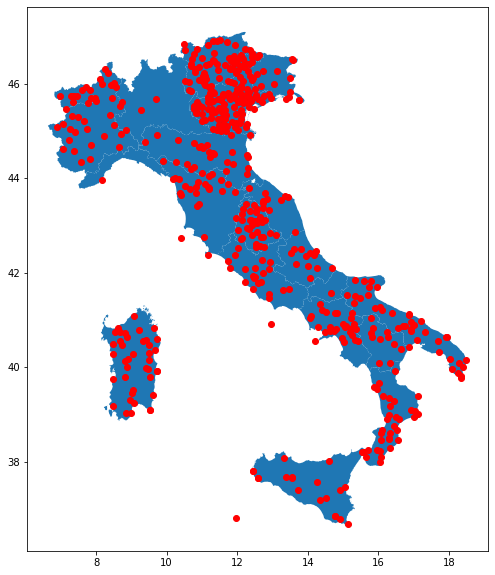

In [8]:
italia=gpd.read_file("italia/italia.shp")

fig,ax=plt.subplots(figsize=(10,10))
italia.plot(ax=ax)
stazioniNonProblematiche.plot(ax=ax,color="red")

### Distribuzione della quota delle stazioni con RMSE inferiore a {{SOGLIA_RMSE}} °C

<AxesSubplot:>

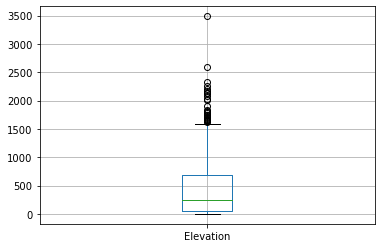

In [9]:
stazioniNonProblematiche[['Elevation']].boxplot()

### Stazioni con RMSE superiore a  {{SOGLIA_RMSE}} °C

Distibuzione spaziale delle serie con un rmse superiore a {{SOGLIA_RMSE}} °C.

Numero di stazioni nella mappa: {{stazioniProblematiche.shape[0]}}

<AxesSubplot:>

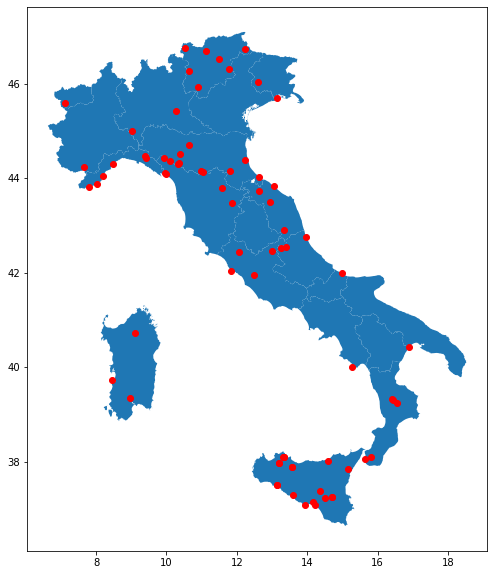

In [10]:
italia=gpd.read_file("italia/italia.shp")
fig,ax=plt.subplots(figsize=(10,10))
italia.plot(ax=ax)
stazioniProblematiche.plot(ax=ax,color="red")

### Distribuzione della quota delle stazioni con RMSE maggiore di {{SOGLIA_RMSE}} °C

<AxesSubplot:>

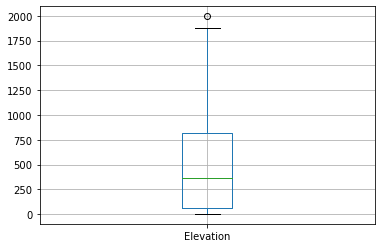

In [11]:
stazioniProblematiche[['Elevation']].boxplot()

### Correzioni applicate da Climatol a livello giornaliero

I grafici che seguono mostrano le correzioni apportate da **Climatol** alle serie giornaliere (differenza fra la serie omogeneizzata e la corrispettiva serie raw).

*Per motivi di spazio i grafici che seguono si riferiscono solo alle serie con rmse >= 1.5 °C.*

In [12]:
def differenza(codice):
  ris=datiOmog[['yy','mm','dd']].copy()
  ris["differenza"]=datiOmog[codice]-datiRaw[codice]
  ris['codice']=codice
  ris['yymmdd']=None
  for index,row in ris.iterrows():
    ris.loc[index,'yymmdd']=str(ris.loc[index,'yy'])+"-"+str(ris.loc[index,'mm'])+"-"+str(ris.loc[index,'dd'])
    
  ris['yymmdd']=pd.to_datetime(ris['yymmdd'],format="%Y-%m-%d")
  return ris

In [13]:
#per velocizzare plottiamo solo serie con rmse >=1.5  
listaOut=[differenza(codice) for codice in stazioniProblematiche[stazioniProblematiche["rmse"]>=1.5].codice]
finale=reduce(lambda x,y: pd.concat([x,y],ignore_index=True),listaOut)  

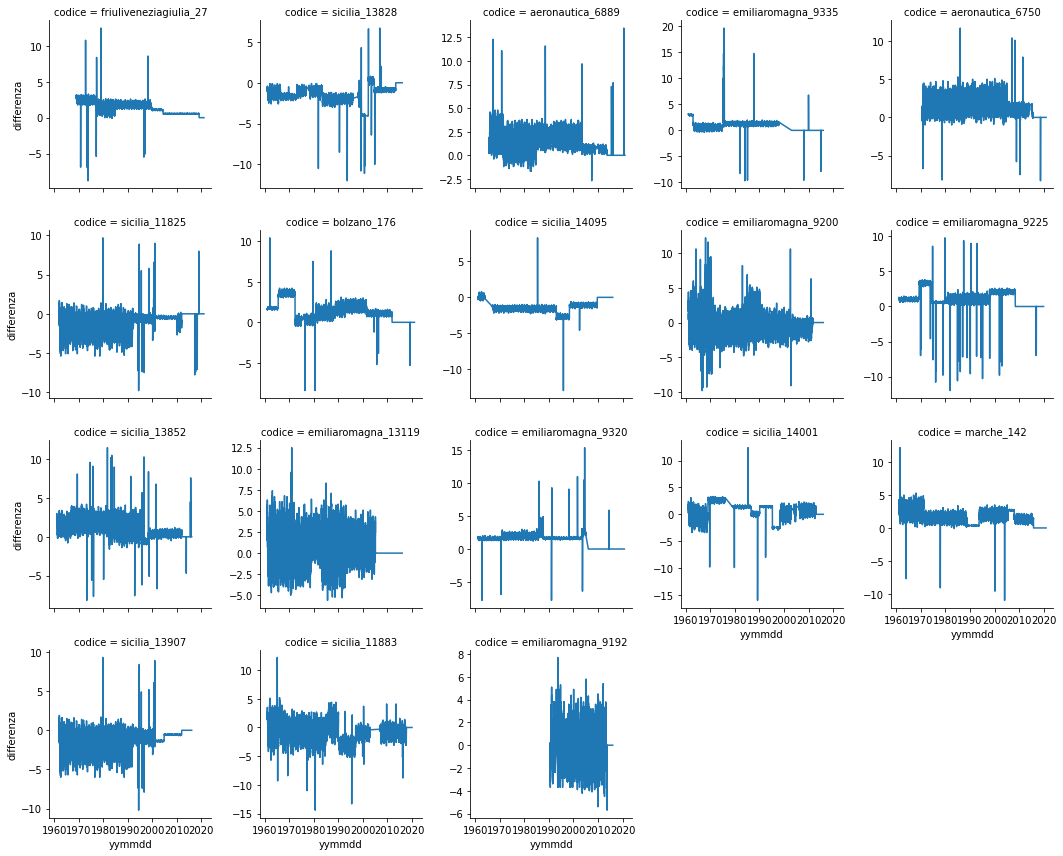

In [14]:
g=sns.FacetGrid(finale,col="codice",col_wrap=5,sharey=False)
g.map(sns.lineplot,"yymmdd","differenza")

### Serie omogeneizzate vs serie raw: confronto della standard deviation

Per ciascun punto stazione calcoliamo la differenza della standard deviation fra la serie omogeneizzata e la rispettiva serie raw.

In [15]:
def funzione(x):
    df=pd.DataFrame({"codice": [x]})
    df["differenzaStd"]=datiOmog[x].std()-datiRaw[x].std()
    return df

In [16]:
listaDiffVar=[funzione(codice) for codice in codiciStazioni]


In [17]:
dfDiffVar=reduce(lambda x,y: pd.concat([x,y],ignore_index=True),listaDiffVar)
dfDiffVar=pd.merge(dfDiffVar,ana,on="codice",how="left")

Descrizione della differenza della standard deviation fra le serie omogeneizzate e le corrispettive serie raw.

In [18]:
dfDiffVar[["differenzaStd"]].describe()

,differenzaStd
count,611.000000
mean,-0.104725
std,0.251874
min,-1.563673
25%,-0.178855
50%,-0.003380
75%,0.014982
max,0.423190


Boxplot della differenza della standard deviation fra le serie omogeneizzate e le corrispettive serie raw.

<AxesSubplot:>

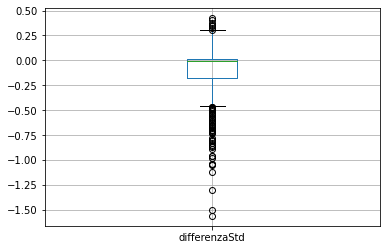

In [19]:
dfDiffVar[["differenzaStd"]].boxplot()

### Serie con rmse minore di {{SOGLIA_RMSE}} °C

Boxplot della differenza della standard deviation fra le serie omogeneizzate e le corrispettive serie raw.

<AxesSubplot:>

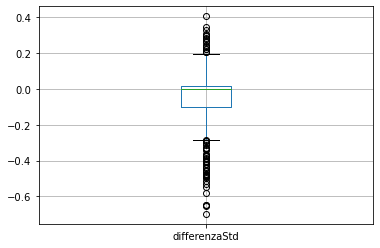

In [20]:
dfDiffVar[dfDiffVar.codice.isin(stazioniNonProblematiche.codice)][["differenzaStd"]].boxplot()

### Serie con rmse superiore a {{SOGLIA_RMSE}} °C

Boxplot della differenza della standard deviation fra le serie omogeneizzate e le corrispettive serie raw.

<AxesSubplot:>

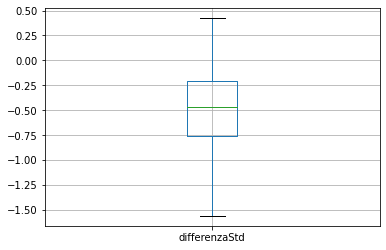

In [21]:
dfDiffVar[dfDiffVar.codice.isin(stazioniProblematiche.codice)][["differenzaStd"]].boxplot()

---

### Confronto fra climatologico stagionale 1991-2020 e climatologico stagionale 1961-1990

Qui di seguito confrontiamo il climatologico stagionale 1991-2020 con il corrispettivo climatologico 1961-1990, distinguendo tra serie che registrano un incremento nel periodo 1991-2020 e serie che registrano un decremento nel corso dello stesso periodo.

In [22]:
datiStagionali=pd.read_csv("climatologici_stagionali_{}_homog.csv".format(PARAM.lower()),
                           sep=";",
                           header=0,
                           dtype={"id":str,"yy":int,"win":float,"spr":float,"sum":float,"aut":float},
                           na_values="NA")

In [23]:
#calcolo della differenza fra climatologico 1991-2020 e climatologico 1961-1990
def differenza_climatologico(x,season):
    subDati=x[["yy","id",season]]
    subDati=subDati.pivot(index="id",columns="yy",values=season)
    subDati.reset_index(drop=False,inplace=True)
    
    for idx,row in subDati.iterrows():
        subDati.loc[idx,"differenza"]=subDati.loc[idx,2005]-subDati.loc[idx,1975]
    
    subDati["season"]=season
    
    return subDati

In [24]:
#calcolo la differenza per ciascuna stagione e stazione
listaDifferenza=[differenza_climatologico(x=datiStagionali,season=stagione) for stagione in ["win","spr","sum","aut"]]

In [25]:
#dfDifferenza contiene il codice della stazione e la differenza fra climatologico 1991-2020 e climatologico 1961-1990
dfDifferenza=reduce(lambda x,y: pd.concat([x,y],ignore_index=True),listaDifferenza).rename(columns={"id":"codice"})

In [26]:
dfDifferenza[dfDifferenza["differenza"].isna()][["codice","season"]].groupby("season").count()

yy,codice
season,
aut,355
spr,347
sum,353
win,365


Per molte stazioni non è possibile calcolare la differenza fra il climatologico 1991-2020 e il climatologico 1961-1990 in quanto si tratta di serie:

- che coprono l'ultimo trentennio climatologico (o solo parte di esso)
- che non hanno abbastanza dati (in base ai criteri del WMO) per il calcolo del trentennio climatologico su entrambi i periodi presi in esame

In [27]:
dfDifferenzaPositiva=dfDifferenza[dfDifferenza["differenza"]>=0]
dfDifferenzaNegativa=dfDifferenza[dfDifferenza["differenza"]<0]

### Stazioni con il climatologico stagionale 1991-2020 maggiore del corrispettivo climatologico 1961-1990

In [28]:
dfDifferenzaPositiva.loc[:,["codice","season"]].groupby("season").count()

yy,codice
season,
aut,135
spr,138
sum,137
win,82


Il boxplot mostra la distribuzione delle differenze tra il climatologico stagionale 1991-2020 e il corrispettivo climatologico 1961-1990.

<AxesSubplot:>

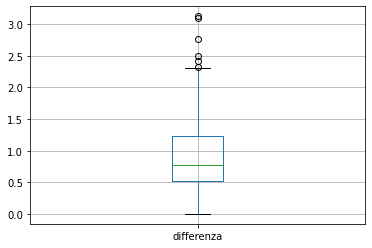

In [29]:
dfDifferenzaPositiva[["differenza"]].boxplot()

Stesso grafico sopra per stagione

<AxesSubplot:title={'center':'differenza'}, xlabel='season'>

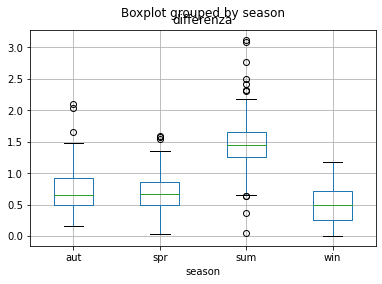

In [30]:
dfDifferenzaPositiva[["season","differenza"]].boxplot(column="differenza",by="season")

### Stazioni con il climatologico stagionale 1991-2020 minore del corrispettivo climatologico 1961-1990

In [31]:
dfDifferenzaNegativa.loc[:,["codice","season"]].groupby("season").count()

yy,codice
season,
spr,5
win,43


Il boxplot mostra la distribuzione delle differenze tra il climatologico stagionale 1991-2020 e il corrispettivo climatologico 1961-1990.

<AxesSubplot:>

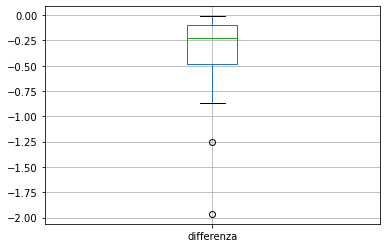

In [32]:
dfDifferenzaNegativa[["differenza"]].boxplot()

Stesso grafico sopra per stagione

<AxesSubplot:title={'center':'differenza'}, xlabel='season'>

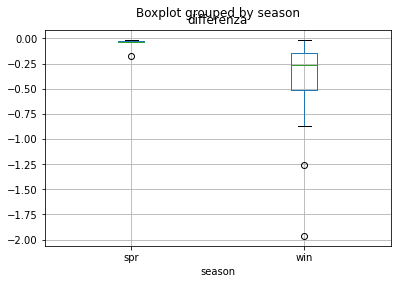

In [33]:
dfDifferenzaNegativa[["season","differenza"]].boxplot(column="differenza",by="season")

La tabella ci dice quante volte (in quante stagioni) una stazione presenta il climatologico 1991-2020 inferiore al climatologico 1961-1990.

In [34]:
dfDifferenzaNegativa[["season","codice"]].groupby("codice").agg("count").reset_index(drop=False).sort_values("season")

yy,codice,season
0,aeronautica_6686,1
23,calabria_290,1
25,emiliaromagna_9015,1
27,lazio_240,1
28,lazio_289,1
29,lazio_333,1
30,marche_142,1
31,sardegna_NU016B554,1
32,sardegna_NU068A007,1
43,toscana_76,1


### Quota delle stazioni con climatologico 1991-2020 inferiore al climatologico 1961-1990

In [35]:
sfDifferenzaNegativa=pd.merge(dfDifferenzaNegativa,ana,on="codice",how="left")

In [36]:
sfDifferenzaNegativa[["Elevation"]].describe()

,Elevation
count,48.000000
mean,243.979167
std,359.413026
min,3.000000
25%,25.000000
50%,72.000000
75%,333.500000
max,1580.000000


<AxesSubplot:>

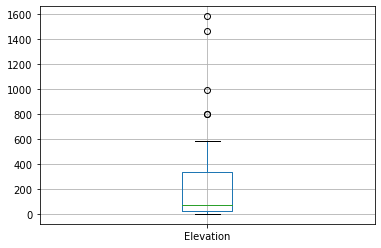

In [37]:
sfDifferenzaNegativa[["Elevation"]].boxplot()

### Mappa delle stazioni con climatologico 1991-2020 inferiore a climatologico 1961-1990

In [38]:
sfDifferenzaNegativa=gpd.GeoDataFrame(sfDifferenzaNegativa.drop(["Longitude","Latitude"],axis=1),crs={"init":"epsg:4326"},geometry=[Point(x,y) for x,y in zip(sfDifferenzaNegativa.Longitude,sfDifferenzaNegativa.Latitude) ])

<AxesSubplot:>

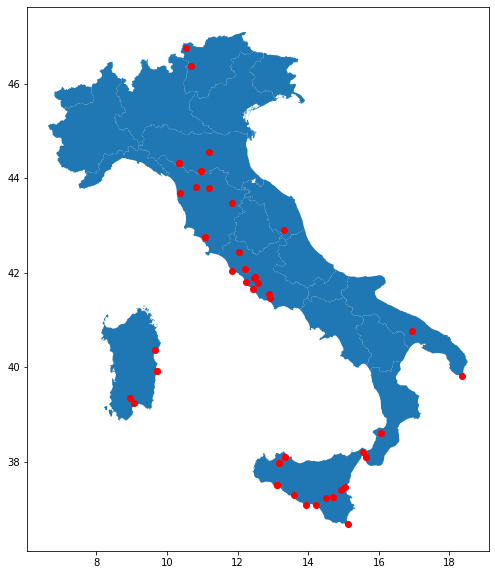

In [39]:
fig,axs=plt.subplots(figsize=(10,10))
italia.plot(ax=axs)
sfDifferenzaNegativa.plot(ax=axs,color="red")

### Mappe stazioni con RMSE superiore a {{SOGLIA_RMSE}} e stazioni con climatologico 91-20 inferiore a climatologico 61-90

Affianchiamo la mappa delle stazioni con rmse superiore a {{SOGLIA_RMSE}} °C e la mappa delle stazioni con differenza negativa tra il climatologico 1991-2020 e il climatologico 1961-1990.

Text(0.5, 1.0, 'Stazioni con climatologico 91-20 <= a climatologico 61-90')

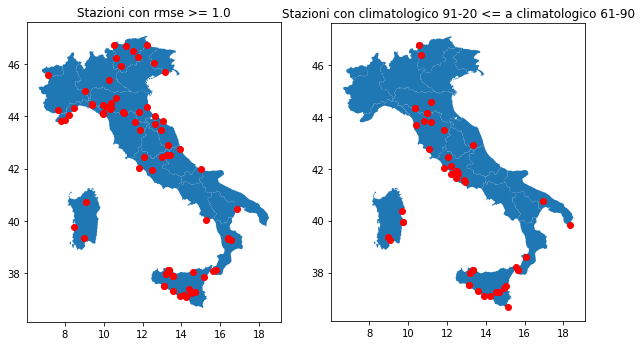

In [40]:
f=plt.figure(figsize=(10,10))
ax=f.add_subplot(1,2,1)
italia.plot(ax=ax)
stazioniProblematiche.plot(ax=ax,color="red")
ax.set_title("Stazioni con rmse >= {}".format(SOGLIA_RMSE))

ax2=f.add_subplot(1,2,2)
italia.plot(ax=ax2)
sfDifferenzaNegativa.plot(ax=ax2,color="red")
ax2.set_title("Stazioni con climatologico 91-20 <= a climatologico 61-90")

In [41]:
dfDifRmse=pd.merge(dfRmse,dfDifferenzaNegativa,on="codice",how="outer")

In [42]:
subDifRmse=dfDifRmse[(~dfDifRmse["rmse"].isna()) & (~dfDifRmse["season"].isna())]

### RMSE vs Differenza (negativa) tra climagolocio 1991-2020 e climatologico 1961-1990

Il grafico si riferisce alle sole stazioni per cui e' stato possibile calcolare la differenza tra il climatologico 1991-2020 e il climatologico 1961-1990 (il grafico si riferisce alle stazioni in cui la differenza tra i due trentenni climatologici è negativa).

<AxesSubplot:xlabel='rmse', ylabel='differenza'>

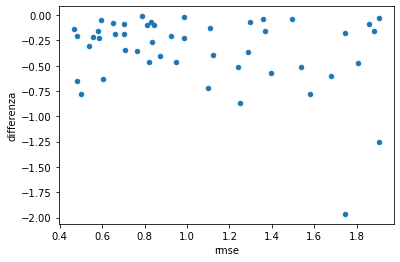

In [43]:
subDifRmse.plot(x="rmse",y="differenza",kind="scatter")

### RMSE vs Differenza (positiva) tra climagolocio 1991-2020 e climatologico 1961-1990

Il grafico si riferisce alle sole stazioni per cui e' stato possibile calcolare la differenza tra il climatologico 1991-2020 e il climatologico 1961-1990 (il grafico si riferisce alle stazioni in cui la differenza tra i due trentenni climatologici è positiva).

In [44]:
dfDifRmse=pd.merge(dfRmse,dfDifferenzaPositiva,on="codice",how="outer")

In [45]:
subDifRmse=dfDifRmse[(~dfDifRmse["rmse"].isna()) & (~dfDifRmse["season"].isna())]

<AxesSubplot:xlabel='rmse', ylabel='differenza'>

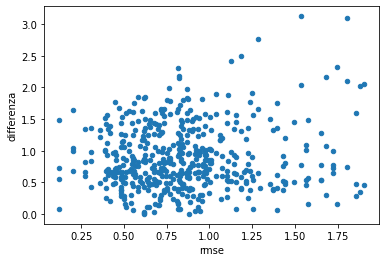

In [46]:
subDifRmse.plot(x="rmse",y="differenza",kind="scatter")